#感情データのモデル作成及びテスト




90分対策  
F12を開いて以下のスクリプトをコンソールで実行  
function KeepClicking(){
console.log("Clicking");
document.querySelector("colab-connect-button").click()
}
setInterval(KeepClicking,600000)

  
10分ごとに接続

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import layers
from keras import models
from tensorflow.keras.layers import Activation, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_dir = '/content/drive/MyDrive/data分析/Face Experience/'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

In [ ]:
train_angry_dir = os.path.join(train_dir, 'angry')
train_disgust_dir = os.path.join(train_dir, 'disgust')
train_fear_dir = os.path.join(train_dir, 'fear')
train_happy_dir = os.path.join(train_dir, 'happy')
train_neutral_dir = os.path.join(train_dir, 'neutral')
train_sad_dir = os.path.join(train_dir, 'sad')
train_suprise_dir = os.path.join(train_dir, 'suprise')

valid_angry_dir = os.path.join(valid_dir, 'angry')
valid_disgust_dir = os.path.join(valid_dir, 'disgust')
valid_fear_dir = os.path.join(valid_dir, 'fear')
valid_happy_dir = os.path.join(valid_dir, 'happy')
valid_neutral_dir = os.path.join(valid_dir, 'neutral')
valid_sad_dir = os.path.join(valid_dir, 'sad')
vaild_suprise_dir = os.path.join(valid_dir, 'suprise')

test_angry_dir = os.path.join(test_dir, 'angry')
test_disgust_dir = os.path.join(test_dir, 'disgust')
test_fear_dir = os.path.join(test_dir, 'fear')
test_happy_dir = os.path.join(test_dir, 'happy')
test_neutral_dir = os.path.join(test_dir, 'neutral')
test_sad_dir = os.path.join(test_dir, 'sad')
test_suprise_dir = os.path.join(test_dir, 'suprise')


##binaryとcategoricalの違い
binaryは0か1かを判定するので2値判定するのに適している  
categoricalは多クラス分類するのに適している  
今回は2つの値を入手する必要があったためcategoricalを使用

##batch_size
ミニバッチ学習に使われるバッチのサイズ  
データの枚数で割り切れるように調整する必要がある  
データの数=batch_size*epochs

##その他
rescaleは正規化のための仕組みでRGB(0~255)で読み込まれた各画素のRGB値を0から1に収まるように正規化
  
target_sizeでサイズ調整

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (48, 48),
    batch_size = 2000,
    class_mode = 'categorical'
)

validation_generator = test_datagen.flow_from_directory(
    valid_dir,
    target_size = (48, 48),
    batch_size = 457,
    class_mode = 'categorical'
)

Found 92975 images belonging to 7 classes.
Found 17366 images belonging to 7 classes.


92975 batch_size=3719,steps=25  
17366 batch_size=457,steps=38

##モデル作成
出力層はsigmoidとsoftmax  
sigmoidは2値、softmaxは多クラスの時に使用  
softmaxを使うとどの特徴にも当てはまらないものも高い数字が出る可能性がある  
input_shape:横,縦,チャンネル数(今回はRGBなので3)  
層を深くしすぎると表現力を失い一直線になる  
Conv2D(16,(3,3)): 3*3の大きさのフィルタを16種類使用  
activation='relu': Relu関数　0より大きい場合はそのまま、0未満は0  
kernel_initializerで重みの初期化  
Relu関数の場合はheの初期値を使うといいかも?




In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 3),kernel_initializer='he_normal'))
model.add(layers.Conv2D(64, (3, 3), activation='relu',kernel_initializer='he_normal'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu',kernel_initializer='he_normal'))
model.add(layers.Conv2D(128, (3, 3), activation='relu',kernel_initializer='he_normal'))
model.add(layers.Conv2D(128, (3, 3), activation='relu',kernel_initializer='he_normal'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu',kernel_initializer='he_normal'))
model.add(layers.Conv2D(256, (3, 3), activation='relu',kernel_initializer='he_normal'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu',kernel_initializer='he_normal'))
model.add(layers.Dense(25, activation='relu',kernel_initializer='he_normal'))
model.add(layers.Dense(7, activation='softmax')) 

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 128)       147584    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0

##Adam
MomentumとAdaGradを融合したような手法

In [ ]:
from tensorflow.keras.optimizers import Adam
adam = Adam(learning_rate=1e-4)
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

モデルを保存　再利用するときに便利

In [ ]:
model.save('/content/drive/MyDrive/data分析/Face Experience/facemodel1.h5')

In [ ]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=46,
                              epochs=5,
                              validation_data=validation_generator,
                              validation_steps=38)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
46/46 [==============================] - 21267s 463s/step - loss: 1.7149 - accuracy: 0.3419 - val_loss: 1.6393 - val_accuracy: 0.3643
Epoch 2/5
46/46 [==============================] - 3009s 65s/step - loss: 1.5782 - accuracy: 0.4138 - val_loss: 1.6021 - val_accuracy: 0.3860
Epoch 3/5
46/46 [==============================] - 3027s 66s/step - loss: 1.5086 - accuracy: 0.4494 - val_loss: 1.5767 - val_accuracy: 0.3858
Epoch 4/5
46/46 [==============================] - 3038s 66s/step - loss: 1.4409 - accuracy: 0.4837 - val_loss: 1.5499 - val_accuracy: 0.4256
Epoch 5/5
46/46 [==============================] - 3020s 66s/step - loss: 1.3899 - accuracy: 0.5098 - val_loss: 1.5251 - val_accuracy: 0.4369


In [ ]:
model.save('/content/drive/MyDrive/data分析/Face Experience/faceweightepoch5.h5')

In [ ]:
#model2=models.load_model('/content/drive/MyDrive/data分析/Face Experience/facemodel1.h5')
model.load_weights('/content/drive/MyDrive/data分析/Face Experience/faceweightepoch5.h5')

In [ ]:
#from tensorflow.keras.optimizers import Adam
#adam = Adam(learning_rate=1e-4)
model2.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint
modelCheckpoint = ModelCheckpoint(filepath ='/content/drive/MyDrive/data分析/Face Experience/faceweightepoch10.h5',
                                  monitor='loss',
                                  verbose=1,
                                  save_best_only=True,
                                  save_weights_only=False,
                                  mode='min',
                                  period=1)

In [ ]:
history2 = model.fit_generator(train_generator,
                              steps_per_epoch=46,
                              epochs=5,
                              verbose=1,
                              validation_data=validation_generator,
                              validation_steps=38,
                              callbacks=[modelCheckpoint])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
46/46 [==============================] - 24489s 533s/step - loss: 1.5471 - accuracy: 0.4442 - val_loss: 1.5402 - val_accuracy: 0.4275

Epoch 00001: val_loss improved from inf to 1.54022, saving model to /content/drive/MyDrive/data分析/Face Experience/faceweightepoch10.h5
Epoch 2/5
46/46 [==============================] - 2740s 59s/step - loss: 1.3444 - accuracy: 0.5246 - val_loss: 1.5110 - val_accuracy: 0.4471

Epoch 00002: val_loss improved from 1.54022 to 1.51104, saving model to /content/drive/MyDrive/data分析/Face Experience/faceweightepoch10.h5
Epoch 3/5
46/46 [==============================] - 2728s 59s/step - loss: 1.3045 - accuracy: 0.5399 - val_loss: 1.5844 - val_accuracy: 0.4270

Epoch 00003: val_loss did not improve from 1.51104
Epoch 4/5
46/46 [==============================] - 2743s 59s/step - loss: 1.2716 - accuracy: 0.5529 - val_loss: 1.5039 - val_accuracy: 0.4526

Epoch 00004: val_loss improved from 1.51104 to 1.50385, saving model to /content/drive/MyDrive/data分析

In [ ]:
history3 = model.fit_generator(train_generator,
                              steps_per_epoch=46,
                              epochs=5,
                              verbose=1,
                              validation_data=validation_generator,
                              validation_steps=38,
                              callbacks=[modelCheckpoint])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
46/46 [==============================] - 2727s 59s/step - loss: 1.2088 - accuracy: 0.5743 - val_loss: 1.4647 - val_accuracy: 0.4592

Epoch 00001: loss improved from inf to 1.20875, saving model to /content/drive/MyDrive/data分析/Face Experience/faceweightepoch10.h5
Epoch 2/5
46/46 [==============================] - 2740s 59s/step - loss: 1.1845 - accuracy: 0.5826 - val_loss: 1.5255 - val_accuracy: 0.4554

Epoch 00002: loss improved from 1.20875 to 1.18455, saving model to /content/drive/MyDrive/data分析/Face Experience/faceweightepoch10.h5
Epoch 3/5
27/46 [================>.............] - ETA: 17:42 - loss: 1.1660 - accuracy: 0.5886

重みを保存　再利用するときに便利


In [ ]:
model.save('/content/drive/MyDrive/data分析/Face Experience/faceweightepoch10.h5')

NameError: ignored

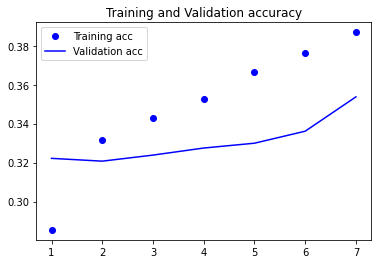

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()
plt.savefig('/content/drive/MyDrive/data分析/Face Experience/accuracy1.png')
plt.show()
plt.close()

In [ ]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/data分析/Face Experience/loss1.png')
plt.show()
plt.close()

In [ ]:
hist_df = pd.DataFrame(history.history)
hist_df.to_csv('/content/drive/MyDrive/data分析/Face Experience/history1.csv')

In [ ]:
hist_df

## 補足
ハイパーパラメータチューニング

In [ ]:
# モデルと重みの読み込み
model2=models.load_model('/content/drive/MyDrive/data分析/Face Experience/facemodel1.h5')
model2.load_weights('/content/drive/MyDrive/data分析/Face Experience/faceweightepoch10.h5')

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_generater = test_datagen.flow_from_directory(
    test_dir,
    target_size =  (48, 48),
    batch_size = 3863,
    class_mode = 'categorical'
)

Found 15452 images belonging to 7 classes.


4と3863
309と50

In [ ]:
test_loss, test_acc = model2.evaluate_generator(test_generater, steps=50)
print('test acc:', test_acc)
print('test loss', test_loss)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


test acc: 0.503365695476532
test loss 1.4044370651245117


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix


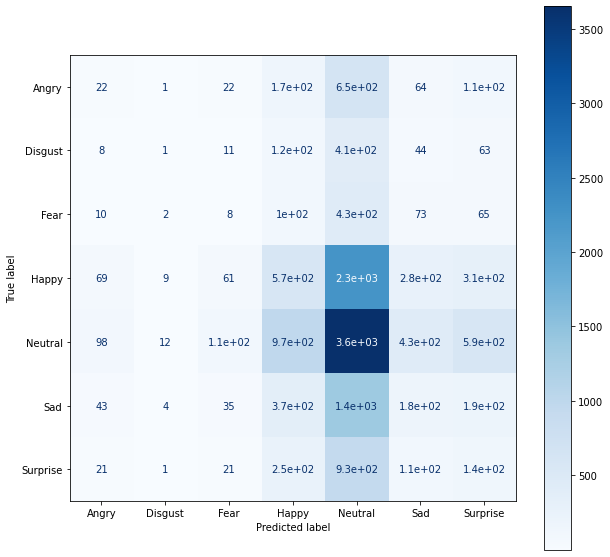

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
Y_pred = model2.predict_generator(test_generater, 4)
y_pred = np.argmax(Y_pred, axis=1)
labels = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]
print("Confusion Matrix")
# confusion matrixの作成
cm = confusion_matrix(test_generater.classes, y_pred)
#表示
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10, 10))
cmd.plot(ax=ax, cmap="Blues")

In [ ]:
import numpy as np
from sklearn import metrics
classes = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(directory=test_dir,
                                                  target_size=(48, 48),
                                                  color_mode='rgb',
                                                  class_mode='categorical',
                                                  batch_size=3863,
                                                  shuffle=False)



Found 15452 images belonging to 7 classes.


In [ ]:
test_steps_per_Epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
#test_steps_per_Epoch=4
predictions = model2.predict_generator(test_generator, steps=test_steps_per_Epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)
# Ground-Truthクラスとクラスラベルを取得する
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# scikit-learnを使用して統計を取得する
report = metrics.classification_report(true_classes,predicted_classes, 
                                       labels=np.arange(len(classes)),
                                       target_names=classes)
print(report)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


              precision    recall  f1-score   support

       Angry       0.49      0.13      0.20      1041
     Disgust       0.10      0.00      0.01       655
        Fear       0.28      0.11      0.15       691
       Happy       0.61      0.44      0.51      3554
     Neutral       0.52      0.85      0.64      5859
         Sad       0.34      0.19      0.24      2177
    Surprise       0.43      0.43      0.43      1475

    accuracy                           0.50     15452
   macro avg       0.39      0.31      0.31     15452
weighted avg       0.47      0.50      0.46     15452

